# 0. Data Setup

In [ ]:
!gdown 18d8LMm61ddRcHLvbncBJjxkA4LijFT-k
!gdown 1dY2Rvck-rsmyuqrciHLsteRurfptK9De
!gdown 1DI9mDSCfOZUc6FIwSdIo7KQPXmz3tYAb

Downloading...
From: https://drive.google.com/uc?id=18d8LMm61ddRcHLvbncBJjxkA4LijFT-k
To: /content/train.csv
100% 6.25M/6.25M [00:00<00:00, 43.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dY2Rvck-rsmyuqrciHLsteRurfptK9De
To: /content/dev.csv
100% 816k/816k [00:00<00:00, 11.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DI9mDSCfOZUc6FIwSdIo7KQPXmz3tYAb
To: /content/test.csv
100% 777k/777k [00:00<00:00, 10.5MB/s]


In [ ]:
%%capture
!pip install nltk
!pip install bert_score
!pip install transformers
!pip install evaluate
!pip install rouge-score

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import random
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from evaluate import load
from rouge_score import rouge_scorer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
train_df = pd.read_csv('train.csv')
dev_df = pd.read_csv('dev.csv')
test_df = pd.read_csv('test.csv')

# 1. Data Preprocessing

Preprocess the data utilizing nltk


*   Apply lower casing
*   Apply tokenization
*   Remove stop words

In [ ]:
def preprocess_text(text):
  text = text.lower()
  text = text.translate(str.maketrans('', '', string.punctuation))
  # tokenize
  tokens = word_tokenize(text)
  # remove stop words
  stop_words = set(stopwords.words('english'))
  tokens = [token for token in tokens if token not in stop_words]
  return tokens

In [ ]:
train_df['clean_reviews'] = train_df['reviewText'].apply(preprocess_text)
dev_df['clean_reviews'] = dev_df['reviewText'].apply(preprocess_text)
test_df['clean_reviews'] = test_df['reviewText'].apply(preprocess_text)

In [ ]:
for i in range(4):
  print("Original Review:", train_df['reviewText'].iloc[i])
  print("Clean Review:", train_df['clean_reviews'].iloc[i])

Original Review: Waaaay too BIG
Clean Review: ['waaaay', 'big']
Original Review: Love these shoes!
Clean Review: ['love', 'shoes']
Original Review: Good indoor training shoes for running on treadmill, doing lunges and regular exercises at the gym. These are very flexible, light weight and comfortable. Grip is okay - sticky rubber is used only at the edges of heel and toe areas so I slipped a little when I worked on cable machines, resistance band, etc. on un-carpeted floor.  I would emphasize that if you do lifting as a part of your everyday routine workout I would not recommend them because mine (cushion) lasted only for six months and this is the reason I gave three stars. Other than that, I liked them!
Clean Review: ['good', 'indoor', 'training', 'shoes', 'running', 'treadmill', 'lunges', 'regular', 'exercises', 'gym', 'flexible', 'light', 'weight', 'comfortable', 'grip', 'okay', 'sticky', 'rubber', 'used', 'edges', 'heel', 'toe', 'areas', 'slipped', 'little', 'worked', 'cable', 'ma

# 2. Simple Baseline Model

Output is *n* randomly selected words from the preprocessed review:

In [ ]:
def simple_model(review, n):
  if len(review) > n:
    return ' '.join(random.sample(review, n))
  else:
     return ' '.join(review)

Sample Outputs:

In [ ]:
for i in range(9,14):
  print("Original Review:", train_df['reviewText'].iloc[i])
  print("Generated Summary:", simple_model(train_df['clean_reviews'].iloc[i], 3))
  print("Original Summary:", train_df['summary'].iloc[i])

Original Review: They fit great. But they fade bad
Generated Summary: great bad fade
Original Summary: Three Stars
Original Review: I've had these shoes for about a week now and have so far enjoyed using them. Considering the fact that I have wide feet, the shoes are slightly tight. However, it doesn't feel uncomfortable nor does it bothers me as I use them throughout my workouts. I know some people personally like when the shoes are a bit tighter or a bit looser so it's all in personal preference.
Generated Summary: bit far shoes
Original Summary: Wide Feet so Somewhat Tight
Original Review: A-MA-ZING!  I needed a good jogging shoe and these make me feel like "Forest Gump".  I felt like I was running on a cloud.  I have narrow feet and these fit perfectly.  I am so happy that I am going to purchase another two pair as back-ups for once it's time to replace them.  Highly recommend to women who like to walk or run and light a light weight, comfortable shoe.
Generated Summary: feet narro

In order to choose our n best words, we will look at the length distribution of our summaries

In [ ]:
processed_summaries = train_df['summary'].apply(preprocess_text)
summary_lengths = processed_summaries.apply(len)

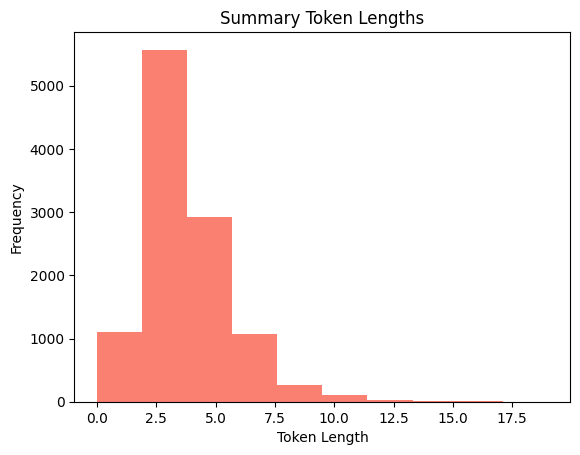

In [ ]:
# Plot distribution of summary token lengths
plt.hist(summary_lengths, bins=10, color='salmon')
plt.title('Summary Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')

plt.show()

It seems that most summaries are at most 8 words, so we chose 8 as the number of words we will sample

# 3. Evaluation

## 3.1 Generation
We first generate the results of our model for each of our datasets

In [ ]:
dev_predictions = dev_df['clean_reviews'].apply(lambda x: simple_model(x, 8))
dev_references = dev_df['summary']

In [ ]:
test_predictions = test_df['clean_reviews'].apply(lambda x: simple_model(x, 8))
test_references = test_df['summary']

In [ ]:
train_predictions = train_df['clean_reviews'].apply(lambda x: simple_model(x, 8))
train_references = train_df['summary']

## 3.2 Evaluation Metrics
We will use both rouge_score and bert_score for our evaluation metrics. We will specifically be looking at the averaged f1 scores of both metrics.

In [ ]:
def rouge_score(prediction, reference):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(prediction, reference)
    return scores

In [ ]:
def evaluate_rouge(predictions, references):
  rouge1_f = 0
  rouge2_f = 0
  rougeL_f = 0

  num_reviews = len(predictions)
  for pred, actual in zip(predictions, references):
    scores = rouge_score(pred, actual)
    rouge1_f += scores['rouge1'][2]
    rouge2_f += scores['rouge2'][2]
    rougeL_f += scores['rougeL'][2]

  rouge1_f = rouge1_f / num_reviews
  rouge2_f = rouge2_f / num_reviews
  rougeL_f = rougeL_f / num_reviews

  return (rouge1_f, rouge2_f, rougeL_f)

In [ ]:
bertscore = load("bertscore")
def evaluate_bert(predictions, references):
  results = bertscore.compute(predictions=predictions,
                              references=references,
                              rescale_with_baseline=True,
                              lang='en')
  f1_scores = results['f1']
  if len(f1_scores) == 0:
    return None

  return sum(f1_scores) / len(f1_scores)

## 3.3 Evaluate Results

In [ ]:
print("Training Eval")
rouge1_f, rouge2_f, rougeL_f = evaluate_rouge(train_predictions, train_references)
bert_f = evaluate_bert(train_predictions, train_references)
print("ROUGE-1 F-Score: ", rouge1_f)
print("ROUGE-2 F-Score: ", rouge2_f)
print("ROUGE-L F-Score: ", rougeL_f)
print("Bert F-Score: ", bert_f)
print("-------------")
print("Dev Eval")
rouge1_f, rouge2_f, rougeL_f = evaluate_rouge(dev_predictions, dev_references)
bert_f = evaluate_bert(dev_predictions, dev_references)
print("ROUGE-1 F-Score: ", rouge1_f)
print("ROUGE-2 F-Score: ", rouge2_f)
print("ROUGE-L F-Score: ", rougeL_f)
print("Bert F-Score: ", bert_f)
print("-------------")
print("Test Eval")
rouge1_f, rouge2_f, rougeL_f = evaluate_rouge(test_predictions, test_references)
bert_f = evaluate_bert(test_predictions, test_references)
print("ROUGE-1 F-Score: ", rouge1_f)
print("ROUGE-2 F-Score: ", rouge2_f)
print("ROUGE-L F-Score: ", rougeL_f)
print("Bert F-Score: ", bert_f)

Training Eval


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1 F-Score:  0.1342140571883173
ROUGE-2 F-Score:  0.01842403681214779
ROUGE-L F-Score:  0.11664315534503712
Bert F-Score:  -0.0029045740087900694
-------------
Dev Eval


ROUGE-1 F-Score:  0.14136148718436897
ROUGE-2 F-Score:  0.022888975383377804
ROUGE-L F-Score:  0.12219361753078514
Bert F-Score:  -0.0036116996233003375
-------------
Test Eval
ROUGE-1 F-Score:  0.13686605384569764
ROUGE-2 F-Score:  0.020183417883853277
ROUGE-L F-Score:  0.11944042113766931
Bert F-Score:  0.0006910461641759854


# 4. Save Results

In [ ]:
def write_to_file(data, file_name):
    with open(file_name, 'w') as txtfile:
        for row in data:
            txtfile.write(str(row) + '\n')

In [ ]:
write_to_file(dev_predictions, 'weak_dev_pred.txt')
write_to_file(dev_references, 'weak_dev_ref.txt')

In [ ]:
write_to_file(test_predictions, 'weak_test_pred.txt')
write_to_file(test_references, 'weak_test_ref.txt')

In [ ]:
write_to_file(train_predictions, 'weak_train_pred.txt')
write_to_file(train_references, 'weak_train_ref.txt')